In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pickle

from utils import plot_graphs


def plot_scores(axs, key: str, values: list[dict], targets: dict, row: int, col: int):
    if len(values) == 0:
        return
    print(values)
    scores = [value["score"] for value in values]
    x = np.arange(1, len(values) + 1)
    axs[row][col].plot(x, scores)

    has_max_scores = "max_score" in values[0]
    has_min_scores = "min_score" in values[0]
    assert (
        has_max_scores == has_min_scores
    ), "Both max_scores and min_scores must be provided or not provided"

    if has_max_scores:
        max_scores = [value["max_score"] for value in values]
        min_scores = [value["min_score"] for value in values]
        axs[row][col].fill_between(x, min_scores, max_scores, alpha=0.5)

    axs[row][col].set_title(
        f"{key} | rolling average: {np.mean(scores[-5:])} | latest: {scores[-1]}"
    )

    axs[row][col].set_xlabel("Game")
    axs[row][col].set_ylabel("Score")

    axs[row][col].set_xlim(1, len(values))

    if len(scores) > 1:
        best_fit_x, best_fit_y = np.polyfit(x, scores, 1)
        axs[row][col].plot(
            x,
            best_fit_x * x + best_fit_y,
            color="g",
            label="Best Fit Line",
            linestyle="dotted",
        )

    if key in targets and targets[key] is not None:
        axs[row][col].axhline(
            y=targets[key],
            color="r",
            linestyle="dashed",
            label="Target Score: {}".format(targets[key]),
        )

    axs[row][col].legend()


def plot_loss(axs, key: str, values: list[dict], targets: dict, row: int, col: int):
    loss = [value["loss"] for value in values]
    x = np.arange(1, len(values) + 1)
    axs[row][col].plot(x, loss)

    axs[row][col].set_title(
        f"{key} | rolling average: {np.mean(loss[-5:])} | latest: {loss[-1]}"
    )

    axs[row][col].set_xlabel("Time Step")
    axs[row][col].set_ylabel("Loss")

    axs[row][col].set_xlim(1, len(values))

    if key in targets and targets[key] is not None:
        axs[row][col].axhline(
            y=targets[key],
            color="r",
            linestyle="dashed",
            label="Target Score: {}".format(targets[key]),
        )

    axs[row][col].legend()

In [2]:
stat_keys_to_plot_funcs = {
    "test_score": plot_scores,
    "score": plot_scores,
    "policy_loss": plot_loss,
    "value_loss": plot_loss,
    "l2_loss": plot_loss,
    "loss": plot_loss,
    "rl_loss": plot_loss,
    "sl_loss": plot_loss,
    # "exploitability": plot_exploitability,  # should this be plot_scores?
}


stats = pickle.load(
    open("./Rainbow_CartPole-v1/step_10000/graphs_stats/stats.pkl", "rb")
)
targets = pickle.load(
    open("./Rainbow_CartPole-v1/step_10000/graphs_stats/targets.pkl", "rb")
)

num_plots = len(stats)
sqrt_num_plots = math.ceil(np.sqrt(num_plots))
fig, axs = plt.subplots(
    sqrt_num_plots,
    sqrt_num_plots,
    figsize=(10 * sqrt_num_plots, 5 * sqrt_num_plots),
    squeeze=False,
)
fig.suptitle("training stats | training step {} | frames seen {}".format(10000, 40000))

for i, (key, values) in enumerate(stats.items()):
    row = i // sqrt_num_plots
    col = i % sqrt_num_plots

    if key in stat_keys_to_plot_funcs:
        stat_keys_to_plot_funcs[key](axs, key, values, targets, row, col)
    else:
        default_plot_func(axs, key, values, targets, row, col)

for i in range(num_plots, sqrt_num_plots**2):
    row = i // sqrt_num_plots
    col = i % sqrt_num_plots
    fig.delaxes(axs[row][col])

# plt.show()
plt.savefig("{}/{}.png".format("./", "rainbow_graph"))

plt.close(fig)

[{'score': 9.0, 'target_model_updated': True}, {'score': 25.0, 'target_model_updated': False}, {'score': 10.0, 'target_model_updated': False}, {'score': 12.0, 'target_model_updated': True}, {'score': 9.0, 'target_model_updated': False}, {'score': 13.0, 'target_model_updated': False}, {'score': 9.0, 'target_model_updated': True}, {'score': 9.0, 'target_model_updated': False}, {'score': 10.0, 'target_model_updated': False}, {'score': 13.0, 'target_model_updated': False}, {'score': 14.0, 'target_model_updated': True}, {'score': 30.0, 'target_model_updated': False}, {'score': 57.0, 'target_model_updated': True}, {'score': 10.0, 'target_model_updated': False}, {'score': 38.0, 'target_model_updated': True}, {'score': 15.0, 'target_model_updated': False}, {'score': 20.0, 'target_model_updated': True}, {'score': 26.0, 'target_model_updated': True}, {'score': 48.0, 'target_model_updated': True}, {'score': 44.0, 'target_model_updated': True}, {'score': 95.0, 'target_model_updated': True}, {'scor

/var/folders/by/wwwbwc016yxfhlbgfph7_xmc0000gn/T/ipykernel_17718/2532135037.py:80: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os


def graph_nfsp_training_graphs(dirs, nodes, game, average=100):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5), squeeze=False)
    for dir, node in zip(dirs, nodes):
        print("plotting nfsp training graph")
        # print(dir)
        print(node)
        stats = pickle.load(open(dir, "rb"))

        # print(stats)
        print(stats.keys())

        print("collecting scores")
        scores = [x["score"] for x in stats["score"]]
        print("computing rolling average")
        rolling_average_scores = [
            np.mean(scores[i - average : i]) for i in range(average, len(scores))
        ]
        # print("computing std dev")
        # std_dev_scores = [
        #     np.std(scores[i - average : i]) for i in range(average, len(scores))
        # ]
        print("collecting losses")
        losses = [x["loss"] for x in stats["loss"]]
        # print(scores)
        print(len(scores))
        print(len(losses))
        # print(len(test_scores))
        print("plotting graph")

        axs[0][0].plot(rolling_average_scores, label=f"{node} Rolling Average Scores")
        # axs[0][0].plot(scores, label="Scores")
        # axs[0][0].fill_between(
        #     range(len(rolling_average_scores)),
        #     np.array(rolling_average_scores) - np.array(std_dev_scores),
        #     np.array(rolling_average_scores) + np.array(std_dev_scores),
        #     alpha=0.5,
        # )
        axs[0][0].set_title("NFSP Training Graph {}".format(game))
        axs[0][0].set_xlabel("Game")
        axs[0][0].set_ylabel("Score")
        axs[0][0].legend()
        axs[0][1].plot(losses, label=f"{node.upper()} Losses")
        axs[0][1].set_title("NFSP Training Graph {}".format(game))
        axs[0][1].set_xlabel("Game")
        axs[0][1].set_ylabel("Loss")
        axs[0][1].legend()
    plt.show()

    plt.savefig(
        "{}/{}.png".format("./", f"nfsp_rainbow_graph_{game}"),
    )  # , bbox_inches='tight', dpi=300)

    plt.close(fig)

plotting nfsp training graph
1M
dict_keys(['score', 'loss', 'test_score'])
collecting scores
computing rolling average
collecting losses
468062
40000
plotting graph
plotting nfsp training graph
4M
dict_keys(['score', 'loss', 'test_score'])
collecting scores
computing rolling average
collecting losses
592542
40000
plotting graph
plotting nfsp training graph
7M
dict_keys(['score', 'loss', 'test_score'])
collecting scores
computing rolling average
collecting losses
505606
40000
plotting graph
plotting nfsp training graph
8M
dict_keys(['score', 'loss', 'test_score'])
collecting scores
computing rolling average
collecting losses
515846
40000
plotting graph
plotting nfsp training graph
10M
dict_keys(['score', 'loss', 'test_score'])
collecting scores
computing rolling average
collecting losses
7627
804
plotting graph


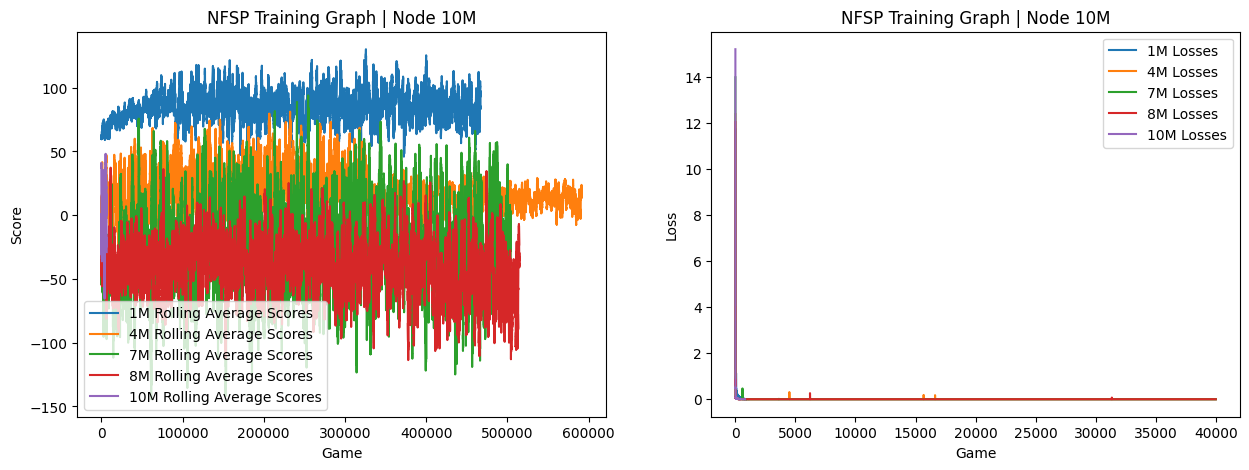

<Figure size 640x480 with 0 Axes>

In [ ]:
dirs = [
    "./checkpoints/Rainbow_leduc_agent_0/stats/stats.pkl",
    "./checkpoints/Rainbow_leduc_agent_1/stats/stats.pkl",
    "./checkpoints/Rainbow_leduc_agent_2/stats/stats.pkl",
    "./checkpoints/Rainbow_leduc_agent_3/stats/stats.pkl",
    "./checkpoints/Rainbow_leduc_agent_4/stats/stats.pkl",
]
nodes = ["1M", "4M", "7M", "8M", "10M"]
graph_nfsp_training_graphs(dirs, nodes, "leduc", average=1000)

plotting nfsp training graph
1M
dict_keys(['score', 'loss', 'test_score'])
collecting scores
computing rolling average
collecting losses
1189098
80000
plotting graph
plotting nfsp training graph
4M
dict_keys(['score', 'loss', 'test_score'])
collecting scores
computing rolling average
collecting losses
823941
80000
plotting graph
plotting nfsp training graph
7M
dict_keys(['score', 'loss', 'test_score'])
collecting scores
computing rolling average
collecting losses
930965
80000
plotting graph
plotting nfsp training graph
8M
dict_keys(['score', 'loss', 'test_score'])
collecting scores
computing rolling average
collecting losses
792830
80000
plotting graph
plotting nfsp training graph
10M
dict_keys(['score', 'loss', 'test_score'])
collecting scores
computing rolling average
collecting losses
623172
80000
plotting graph


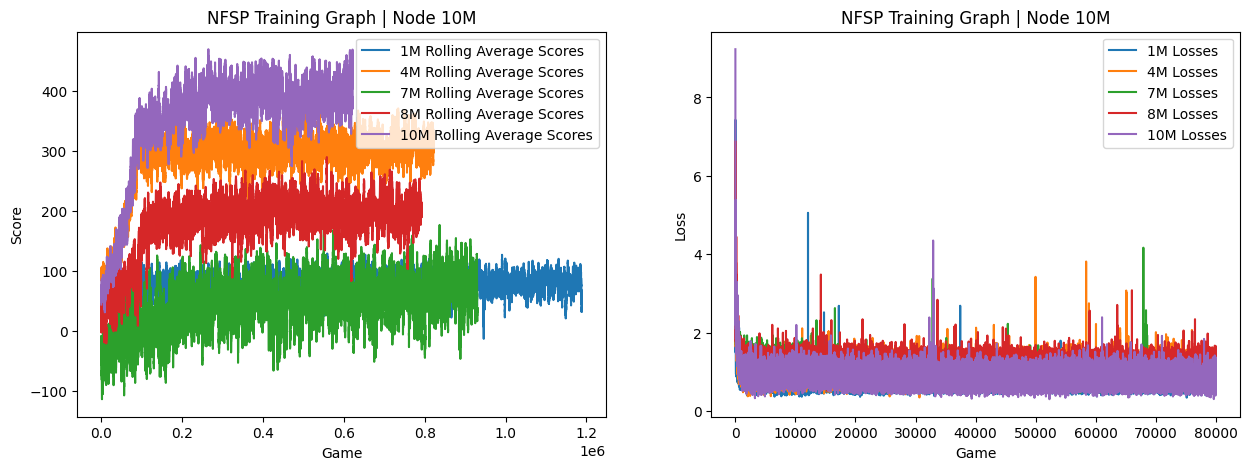

<Figure size 640x480 with 0 Axes>

In [ ]:
dirs = [
    "./checkpoints/Rainbow2_fhp_agent_0/stats/stats.pkl",
    "./checkpoints/Rainbow2_fhp_agent_1/stats/stats.pkl",
    "./checkpoints/Rainbow2_fhp_agent_2/stats/stats.pkl",
    "./checkpoints/Rainbow2_fhp_agent_3/stats/stats.pkl",
    "./checkpoints/Rainbow2_fhp_agent_4/stats/stats.pkl",
]
nodes = ["1M", "4M", "7M", "8M", "10M"]
graph_nfsp_training_graphs(dirs, nodes, "fhp", average=1000)

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# RAINBOW BEST RESPONSE FOR NFSP 1M, 4M, 7M, 8M, 10M on x-axis
stats_1m = pickle.load(open("./checkpoints/Rainbow2_fhp_agent_0/stats/stats.pkl", "rb"))
stats_4m = pickle.load(open("./checkpoints/Rainbow2_fhp_agent_1/stats/stats.pkl", "rb"))
stats_7m = pickle.load(open("./checkpoints/Rainbow2_fhp_agent_2/stats/stats.pkl", "rb"))
stats_8m = pickle.load(open("./checkpoints/Rainbow2_fhp_agent_3/stats/stats.pkl", "rb"))
stats_10m = pickle.load(
    open("./checkpoints/Rainbow2_fhp_agent_4/stats/stats.pkl", "rb")
)

scores_1m = [x["score"] for x in stats_1m["score"]]
scores_4m = [x["score"] for x in stats_4m["score"]]
scores_7m = [x["score"] for x in stats_7m["score"]]
scores_8m = [x["score"] for x in stats_8m["score"]]
scores_10m = [x["score"] for x in stats_10m["score"]]

final_rolling_average_score_1m = np.mean(scores_1m[-5000:])
final_rolling_average_score_4m = np.mean(scores_4m[-5000:])
final_rolling_average_score_7m = np.mean(scores_7m[-5000:])
final_rolling_average_score_8m = np.mean(scores_8m[-5000:])
final_rolling_average_score_10m = np.mean(scores_10m[-5000:])
final_std_dev_score_1m = np.std(scores_1m[-5000:])
final_std_dev_score_4m = np.std(scores_4m[-5000:])
final_std_dev_score_7m = np.std(scores_7m[-5000:])
final_std_dev_score_8m = np.std(scores_8m[-5000:])
final_std_dev_score_10m = np.std(scores_10m[-5000:])

print("Final Rolling Average Score 1M: ", final_rolling_average_score_1m)
print("Final Rolling Average Score 4M: ", final_rolling_average_score_4m)
print("Final Rolling Average Score 7M: ", final_rolling_average_score_7m)
print("Final Rolling Average Score 8M: ", final_rolling_average_score_8m)
print("Final Rolling Average Score 10M: ", final_rolling_average_score_10m)

print("Final Std Dev Score 1M: ", final_std_dev_score_1m)
print("Final Std Dev Score 4M: ", final_std_dev_score_4m)
print("Final Std Dev Score 7M: ", final_std_dev_score_7m)
print("Final Std Dev Score 8M: ", final_std_dev_score_8m)
print("Final Std Dev Score 10M: ", final_std_dev_score_10m)

x = [
    1e6,
    4e6,
    7e6,
    8e6,
    10e6,
]  # x-axis values for the number of nodes

y = [
    final_rolling_average_score_1m,
    final_rolling_average_score_4m,
    final_rolling_average_score_7m,
    final_rolling_average_score_8m,
    final_rolling_average_score_10m,
]  # y-axis values for the rolling average scores

yerr = [
    final_std_dev_score_1m,
    final_std_dev_score_4m,
    final_std_dev_score_7m,
    final_std_dev_score_8m,
    final_std_dev_score_10m,
]  # y-axis values for the rolling average scores

# Plotting
fig, axs = plt.subplots(1, 1, figsize=(10, 5), squeeze=False)
axs[0][0].plot(
    x,
    y,
    marker="o",
    markersize=8,
    color="blue",
    label="Rolling Average Score",
)
axs[0][0].errorbar(
    x,
    y,
    yerr=yerr,
    fmt="o",
    capsize=5,
    capthick=2,
    elinewidth=2,
    label="Rolling Average Score",
)
axs[0][0].set_title("NFSP with Rainbow Best Response Opponent Training Graph (FHP)")
axs[0][0].set_xlabel("Number of Nodes")
axs[0][0].set_ylabel("Rolling Average Score")
axs[0][0].set_xscale("log")
axs[0][0].set_xlim(1e6, 10e6)
# axs[0][0].set_ylim(0, 1)
axs[0][0].set_xticks([1e6, 4e6, 7e6, 8e6, 10e6])
axs[0][0].set_xticklabels(["1M", "4M", "7M", "8M", "10M"])  # Set custom x-tick labels
axs[0][0].legend()
plt.savefig(
    "{}/{}.png".format("./", "nfsp_rainbow_graph_fhp"),
)  # , bbox_inches='tight', dpi=300)

Final Rolling Average Score 1M:  76.16
Final Rolling Average Score 4M:  311.22
Final Rolling Average Score 7M:  66.12
Final Rolling Average Score 8M:  207.53
Final Rolling Average Score 10M:  390.63
Final Std Dev Score 1M:  452.56894988498715
Final Std Dev Score 4M:  612.3733433127213
Final Std Dev Score 7M:  890.3067705010448
Final Std Dev Score 8M:  599.8506473281495
Final Std Dev Score 10M:  791.0339456053705


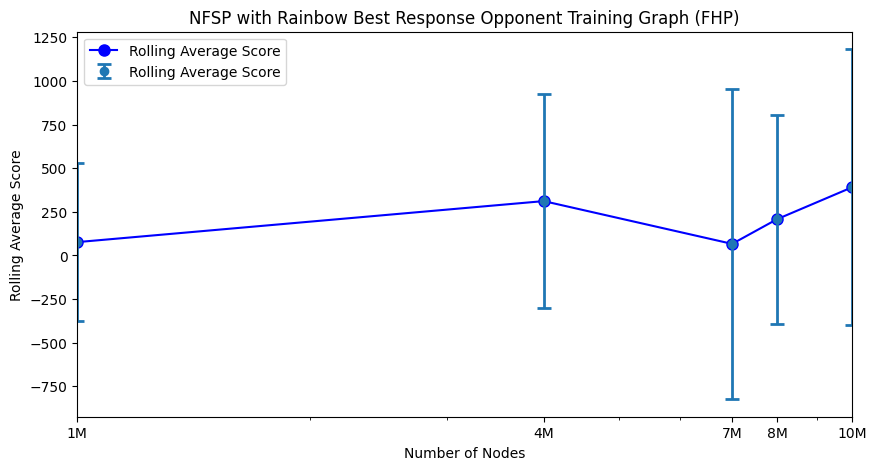

In [ ]:
# RAINBOW BEST RESPONSE FOR NFSP 1M, 4M, 7M, 8M, 10M on x-axis
stats_1m = pickle.load(
    open("./checkpoints/Rainbow_leduc_agent_0/stats/stats.pkl", "rb")
)
stats_4m = pickle.load(
    open("./checkpoints/Rainbow_leduc_agent_1/stats/stats.pkl", "rb")
)
stats_7m = pickle.load(
    open("./checkpoints/Rainbow_leduc_agent_2/stats/stats.pkl", "rb")
)
stats_8m = pickle.load(
    open("./checkpoints/Rainbow_leduc_agent_3/stats/stats.pkl", "rb")
)
stats_10m = pickle.load(
    open("./checkpoints/Rainbow_leduc_agent_4/stats/stats.pkl", "rb")
)

scores_1m = [x["score"] for x in stats_1m["score"]]
scores_4m = [x["score"] for x in stats_4m["score"]]
scores_7m = [x["score"] for x in stats_7m["score"]]
scores_8m = [x["score"] for x in stats_8m["score"]]
scores_10m = [x["score"] for x in stats_10m["score"]]

final_rolling_average_score_1m = np.mean(scores_1m[-5000:])
final_rolling_average_score_4m = np.mean(scores_4m[-5000:])
final_rolling_average_score_7m = np.mean(scores_7m[-5000:])
final_rolling_average_score_8m = np.mean(scores_8m[-5000:])
final_rolling_average_score_10m = np.mean(scores_10m[-5000:])
final_std_dev_score_1m = np.std(scores_1m[-5000:])
final_std_dev_score_4m = np.std(scores_4m[-5000:])
final_std_dev_score_7m = np.std(scores_7m[-5000:])
final_std_dev_score_8m = np.std(scores_8m[-5000:])
final_std_dev_score_10m = np.std(scores_10m[-5000:])

print("Final Rolling Average Score 1M: ", final_rolling_average_score_1m)
print("Final Rolling Average Score 4M: ", final_rolling_average_score_4m)
print("Final Rolling Average Score 7M: ", final_rolling_average_score_7m)
print("Final Rolling Average Score 8M: ", final_rolling_average_score_8m)
print("Final Rolling Average Score 10M: ", final_rolling_average_score_10m)

print("Final Std Dev Score 1M: ", final_std_dev_score_1m)
print("Final Std Dev Score 4M: ", final_std_dev_score_4m)
print("Final Std Dev Score 7M: ", final_std_dev_score_7m)
print("Final Std Dev Score 8M: ", final_std_dev_score_8m)
print("Final Std Dev Score 10M: ", final_std_dev_score_10m)

x = [
    1e6,
    4e6,
    7e6,
    8e6,
    10e6,
]  # x-axis values for the number of nodes

y = [
    final_rolling_average_score_1m,
    final_rolling_average_score_4m,
    final_rolling_average_score_7m,
    final_rolling_average_score_8m,
    final_rolling_average_score_10m,
]  # y-axis values for the rolling average scores

yerr = [
    final_std_dev_score_1m,
    final_std_dev_score_4m,
    final_std_dev_score_7m,
    final_std_dev_score_8m,
    final_std_dev_score_10m,
]  # y-axis values for the rolling average scores

# Plotting
fig, axs = plt.subplots(1, 1, figsize=(10, 5), squeeze=False)
axs[0][0].plot(
    x,
    y,
    marker="o",
    markersize=8,
    color="blue",
    label="Rolling Average Score",
)
axs[0][0].errorbar(
    x,
    y,
    yerr=yerr,
    fmt="o",
    capsize=5,
    capthick=2,
    elinewidth=2,
    label="Rolling Average Score",
)
axs[0][0].set_title("NFSP with Rainbow Best Response Opponent Training Graph (Leduc)")
axs[0][0].set_xlabel("Number of Nodes")
axs[0][0].set_ylabel("Rolling Average Score")
axs[0][0].set_xscale("log")
axs[0][0].set_xlim(1e6, 10e6)
# axs[0][0].set_ylim(0, 1)
axs[0][0].set_xticks([1e6, 4e6, 7e6, 8e6, 10e6])
axs[0][0].set_xticklabels(["1M", "4M", "7M", "8M", "10M"])  # Set custom x-tick labels
axs[0][0].legend()
plt.savefig(
    "{}/{}.png".format("./", "nfsp_rainbow_graph_leduc"),
)  # , bbox_inches='tight', dpi=300)